In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(42)
# Data
np.random.seed(42)

d = 2
T = 25
N = 1000
rho = 0.5
Y = np.random.multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]], size=(N,))

u = 1 / T * (np.arange(0, T) + 1)
U1, U2 = np.meshgrid(*([u,]*d)) # not handling d>2
U = np.stack([U1.reshape(-1), U2.reshape(-1)], axis=1)

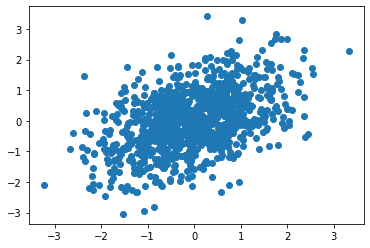

In [31]:
plt.scatter(Y[:, 0], Y[:, 1])

In [32]:
from scipy.spatial.distance import cdist

# Pairwise distances (similarity)
# U @ Y.T
S = cdist(U, Y, lambda x, y: x.dot(y))  # original: why only inner product?
S.shape

(625, 1000)

In [33]:
Td = T ** d

one_N = np.ones([N, 1])
one_T = np.ones([Td, 1])
Pi_cp = cp.Variable(shape=(Td, N))

objective = cp.sum(cp.multiply(Pi_cp, S))

constraints = [
    Pi_cp @ one_N == 1 / Td * one_T,
    Pi_cp >= 0,
    one_T.T @ Pi_cp == 1 / N * one_N.T,
]

problem = cp.Problem(objective=cp.Maximize(objective), constraints=constraints)
problem.solve(verbose=True,)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 23 07:15:24 PM: Your problem has 625000 variables, 3 constraints, and 0 parameters.
(CVXPY) Jul 23 07:15:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 23 07:15:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 23 07:15:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 23 07:15:24 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 23 07:15:24 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

0.5029708135785562

In [34]:
EPS=0.0001

def b_to_quantile(f, T, U1, U2, step):
    fact=10/step
    l=T.shape[0]
    m=U1.shape[0]
    D1=np.zeros(m)
    D2=np.zeros(m)
    for i1 in range(1, l):
        u1=T[i1]
        for i2 in range(1, l):
            u2=T[i2]
            j=np.where((fact*U1 + U2)==(fact*u1+u2))
            jprecx=np.where(abs((fact*U1 + U2)-(fact*(u1-step)+u2))<EPS)
            jprecy=np.where(abs((fact*U1 + U2)-(fact*u1+(u2-step)))<EPS)
            D1[j]=(f[j]-f[jprecx])/step
            D2[j]=(f[j]-f[jprecy])/step
    return D1, D2

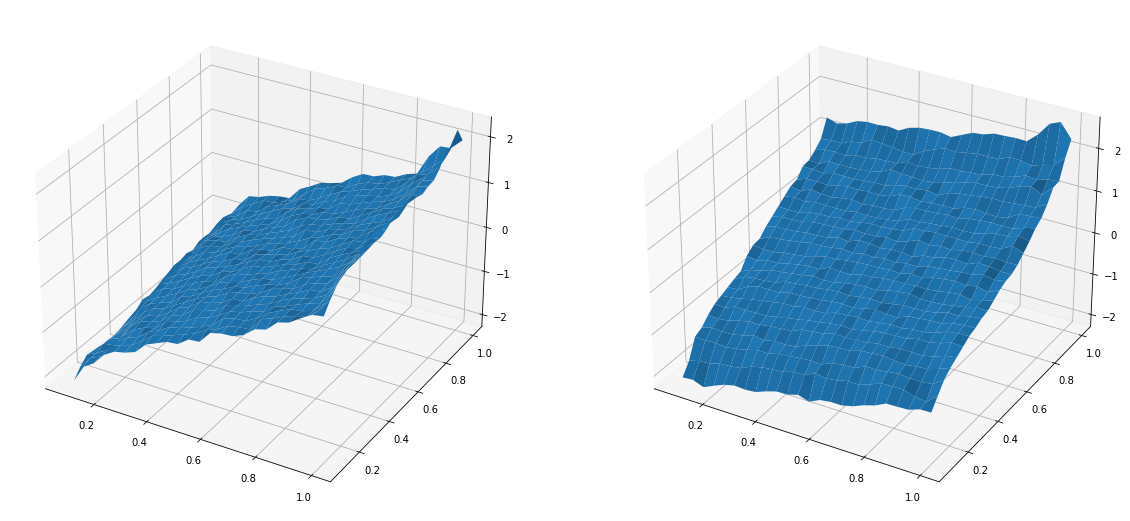

In [35]:
Q1, Q2 = b_to_quantile(constraints[0].dual_value, u, U1.reshape(-1), U2.reshape(-1), 1/T)
Q1 = Q1.reshape([25, 25])
Q2 = Q2.reshape([25, 25])

fig, ax = plt.subplots(1, d, figsize=(20, 10), subplot_kw={"projection": "3d"})

ax[0].plot_surface(U1[1:, 1:], U2[1:, 1:], Q1[1:, 1:])
ax[1].plot_surface(U1[1:, 1:], U2[1:, 1:], Q2[1:, 1:])

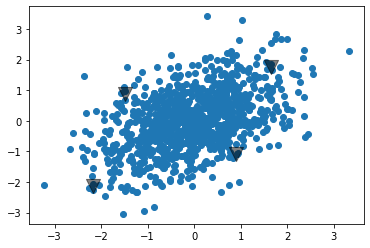

In [36]:
q_10_90 = [Q1[ 1, -2], Q2[ 1, -2]]
q_90_90 = [Q1[-2, -2], Q2[-2, -2]]
q_90_10 = [Q1[-2,  1], Q2[-2,  1]]
q_10_10 = [Q1[ 1,  1], Q2[ 1,  1]]

plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(q_10_90[0], q_10_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_90[0], q_90_90[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_90_10[0], q_90_10[1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(q_10_10[0], q_10_10[1], alpha=.5, color='k', s=200, marker='v')

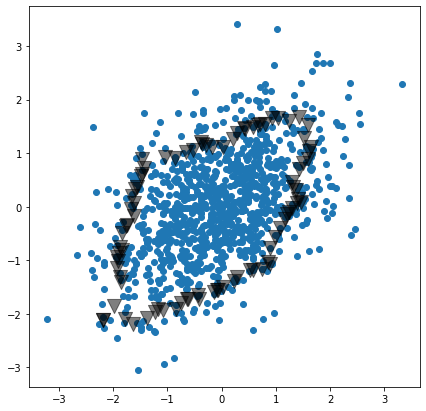

In [47]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(Q1[1:-2, -2], Q2[1:-2, -2], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[1, 1:-2], Q2[1, 1:-2], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[1:-2, 1], Q2[1:-2, 1], alpha=.5, color='k', s=200, marker='v')
plt.scatter(Q1[-2, 1:-2], Q2[-2, 1:-2], alpha=.5, color='k', s=200, marker='v')

surface = np.array([[*Q1[1:-2, -2], *Q1[1, 1:-2], *Q1[1:-2, 1], *Q1[-2, 1:-2]],
                    [*Q2[1:-2, -2], *Q2[1, 1:-2], *Q2[1:-2, 1], *Q2[-2, 1:-2]]]).T

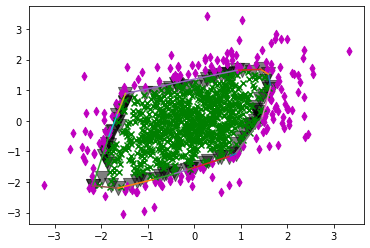

In [49]:
from scipy.spatial import ConvexHull

def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

selected_Y = surface
hull = ConvexHull(selected_Y)
for simplex in hull.simplices:
    plt.plot(selected_Y[simplex, 0], selected_Y[simplex, 1])
    
plt.scatter(*selected_Y.T, alpha=.5, color='k', s=200, marker='v')

coverage = []
for p in Y:
    point_is_in_hull = point_in_hull(p, hull)
    coverage.append(point_is_in_hull)
    marker = 'x' if point_is_in_hull else 'd'
    color = 'g' if point_is_in_hull else 'm'
    plt.scatter(p[0], p[1], marker=marker, color=color)

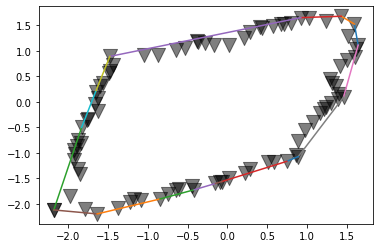

In [55]:
plt.scatter(*selected_Y.T, alpha=.5, color='k', s=200, marker='v')
for simplex in hull.simplices:
    plt.plot(selected_Y[simplex, 0], selected_Y[simplex, 1])

In [58]:
(sum(coverage)/len(coverage))*100

81.2